In [1]:
using ODBC

In [2]:
ODBC.dsns()

Dict{String,String} with 1 entry:
  "ricohnz-db2" => "SQL Server"

In [4]:
conn = ODBC.Connection("ricohnz-db2")

+ Info: 01000: [Microsoft][ODBC SQL Server Driver][SQL Server]Changed database context to 'master'.01000: [Microsoft][ODBC SQL Server Driver][SQL Server]Changed language setting to us_english.
+ @ ODBC.API C:\Users\Ajefferi\.julia\packages\ODBC\2MEHX\src\API.jl:112


ODBC.Connection(ricohnz-db2)

In [16]:
query1 = """

SELECT [CNNO02] as ContractNo
      ,[CNTY02] as contractType
      ,[INNO02] as Model
      ,[INTY02]	as Serial
    
      ,[ACNO02] as AccountNo
      ,[LOCN02] as 'Location'
 

      ,[STRD02] as DateOpened --note that there is some misinformation for this one,maybe startdates and enddates accidentally switched around
      ,[TRMD02] as DateClosed
      ,[CCRC02] as TerminationCode

      ,[RSPT02] as Code2

      ,[NPRD02] as  DateMatured
  
      ,[MTRD02] as MeterDate

      , c.DSMC02 as Code3
	  ,datediff(day,[STRD02],[TRMD02]) as TermUsed,
	  datediff(day,[TRMD02],[NPRD02]) as termRemaining
 
  FROM [SYS21].[dbo].[CBP02] c
"""


query2 = 
"""
/****** Script for SelectTopNRows command from SSMS  ******/


select  t.AccountNo,min(DateOpened) as custStart,
	max(t.DateClosed) as custEnd,
	Datediff(day,max(DateClosed),min(t.DateOpened)) * -1 as RetentionLen ,
	
	
	avg(datediff(DAY, DateClosed,DateMatured)) as avgTermLeft,
	avg(datediff(DAY,DateClosed,DateOpened)) *-1 as avgTermUsed ,
	sum(datediff(DAY,DateMatured,DateOpened)) *-1 as totalTermRem, 
	sum(datediff(DAY,DateClosed,DateOpened)) * -1 as totalUsedTerm,
	count(distinct t.ContractNo) as numLeases --,datediff(month,EndDate,meterdate) as verify -- meter read date can indicate within 2 months how long the machine was in use for after ther contract ended 

from

(SELECT [CNNO02] as ContractNo
      ,[CNTY02] as contractType
      ,[INNO02] as Model
      ,[INTY02]	as Serial
    
      ,[ACNO02] as AccountNo
      ,[LOCN02] as 'Location'
 

      ,[STRD02] as DateOpened
      ,[TRMD02] as DateClosed
      ,[CCRC02] as TerminationCode

      ,[RSPT02] as Code2

      ,[NPRD02] as  DateMatured
  
      ,[MTRD02] as MeterDate

      , c.DSMC02 as Code3
	  ,datediff(day,[STRD02],[TRMD02]) as TermUsed,
	  datediff(day,[TRMD02],[NPRD02]) as termRemaining
 
  FROM [SYS21].[dbo].[CBP02] c
  --filter out to exclude currently open contracts
  
  
  ) t

  --
 where AccountNO in 


 
(select Account
 FROM  [Ricoh_SAS].[dbo].[RicohFinance_Contracts] fc 
  where  
 --


    SalesPlan = 'Copy Plan' and DealType = 'Original' and not Branch = 'HO' and DealSize ='Less than 10K' or DealSize = '30K to 50K'
	and Segment not in ('Local Government', 'Local Major Account','Global Major Account','Ex Global Major Account'))


 group by t.AccountNo
 --order by datediff(month,maturedate,meterdate) asc
having max(t.DateClosed) is not null and max(t.DateClosed) >= min(t.DateOpened) -- WHy do we get negative retention lentghts?

"""

query3 ="""
/****** Script for SelectTopNRows command from SSMS  ******/
SELECT 
      [PSAR12] as TerminationCode
      ,[DESC12] as 'Description'
    
  FROM [SYS21].[dbo].[SSP12]

"""


query4 = """



"""



"/****** Script for SelectTopNRows command from SSMS  ******/\nSELECT \n      [PSAR12] as TerminationCode\n      ,[DESC12] as 'Description'\n    \n  FROM [SYS21].[dbo].[SSP12]\n\n"

In [177]:
using DataFrames

condf = DBInterface.execute(conn,query1) |> DataFrame

custdf = DBInterface.execute(conn,query2) |> DataFrame

lookdf = DBInterface.execute(conn,query3) |> DataFrame;

In [178]:
using StatsPlots

In [179]:
using Dates
head(lookdf)

,TerminationCode,Description
,String,String?
1,A,MIF = 40+
2,B,MIF = 10 - 39
3,C,MIF = 1 - 9
4,IGN,Ignore
5,PAP,Paper
6,SBK,Staple Booklet


In [180]:
termlook = lookdf[219:244,:]


contractdf = join(condf,termlook,on ="TerminationCode" );

In [181]:
names(contractdf)

16-element Array{String,1}:
 "ContractNo"
 "contractType"
 "Model"
 "Serial"
 "AccountNo"
 "Location"
 "DateOpened"
 "DateClosed"
 "TerminationCode"
 "Code2"
 "DateMatured"
 "MeterDate"
 "Code3"
 "TermUsed"
 "termRemaining"
 "Description"

In [182]:
##return the enddates of the customers , the final codes used as well as the amount of term remaining in that contract


unique(contractdf.Description)


26-element Array{Union{Missing, String},1}:
 "Move to Competitor - Konica"
 "In Liquidation - Receivership"
 "Contract Entered in Error"
 "Move to Competitor - Toshiba"
 "Contract Changed - Meters"
 "Transferred to new Contract"
 "Move to Competitor - Canon"
 "Upgraded with Ricoh"
 "Cstmr Rqst -Machine not in use"
 "Move to Competitor - Panasonic"
 "Move to Competitor - Other"
 "Customer Request - To T&M"
 "Move to Competitor - Xerox"
 "Equipment to be Obsolete"
 "Scrapped **Do not Use**"
 "Assigned to another Customer"
 "Metering Admin Machine-To T&M"
 "Customer Request - Business"
 "Dealer Request"
 "Move to Competitor - HP"
 "Cstmr Dissatisfied- Terminated"
 "Customer to Collection"
 "Swap-Out"
 "Move to Competitor - Sharp"
 "Contract Changed - Type"
 "Contract Changed - Rates"

In [183]:
contractdf.Poached = [occursin("Move",element) ? "p" : "n" for element in contractdf.Description];
contractdf.Terminated = [occursin("Terminated",element) ? "t" : "n" for element in contractdf.Description];

In [156]:
using DelimitedFiles


In [185]:
##filter accounts by parent accounts as well as add the sales rep fied

salesmap = DelimitedFiles.readdlm("C:/Users/Ajefferi/Documents/SalesMapCusts.txt",skipstart=2) |> DataFrame

#select(salesmap,x1=>"AccountNo",x2=>"SalesRep")
names(salesmap)


names!(salesmap, [:AccountNo,:SalesRep]);




salesmap.AccountNo = string.(salesmap.AccountNo)

custdf = outerjoin(custdf, salesmap, on = "AccountNo")

LoadError: ArgumentError: Duplicate variable names: :SalesRep. Pass makeunique=true to make them unique using a suffix automatically.

In [186]:
## mislabeled contracts 


mislabels = DelimitedFiles.readdlm("C:/Users/Ajefferi/Documents/MislabeledContracts.txt",skipstart=2,String);

for i in length(contractdf.AccountNo)

    contractdf.AccountNo[i] ? mislabels ? contractdf.contractType[i] = "VOL" : donothing=true
    
end

In [126]:
childcusts = DelimitedFiles.readdlm("C:/Users/Ajefferi/Documents/ChildCustomers.txt ",skipstart=0,String);

In [162]:
for i in length(custdf.AccountNo)
    custdf.IsChild =[false for acc in custdf.AccountNo]
    custdf.AccountNo[i] ? childcusts ? custdf.IsChild[i] = true : custdf.IsChild[i] = false
    
    
    
end

In [164]:
names(custdf)

11-element Array{String,1}:
 "AccountNo"
 "custStart"
 "custEnd"
 "RetentionLen"
 "avgTermLeft"
 "avgTermUsed"
 "totalTermRem"
 "totalUsedTerm"
 "numLeases"
 "IsChild"
 "SalesRep"

In [235]:
## obtain the leaving points of the customers 

contractdf = contractdf[contractdf.contractType .== "CPY",:]


contractdf = contractdf[contractdf.termRemaining .>= 0,:]

## obtain the poaching points of the  customers
termrem = Array{Any}(contractdf.termRemaining)
termuse = Array{Any}(contractdf.TermUsed)


11845-element Array{Any,1}:
    0
  426
  880
 1280
 2375
 1215
 2952
 2931
  517
 1698
 1704
 2375
 2963
    ?
    1
   25
   32
  122
   93
   78
   32
   42
   32
   32
   61
    1

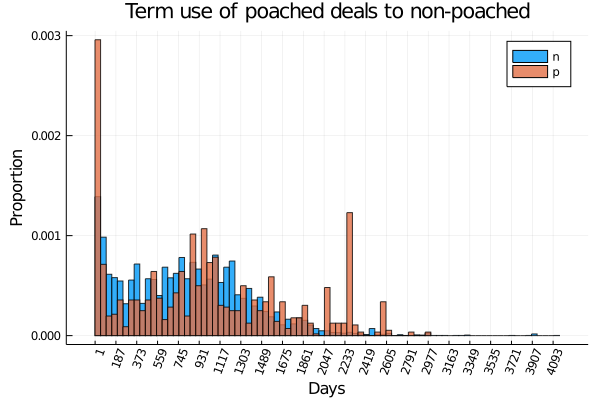

In [264]:
##plot the lengths and term remaining of each of these


#StatsPlots.groupedhist(contractdf.termRemaining,group=contractdf.Terminated)
p=1
histogram(termuse,normed=true,xrotation=70,xticks = [i for i in 1:6*31:maximum(termuse)],group = contractdf.Poached,nbins =100,alpha = 0.8,bar_position = :stack,xlabel="Days",ylabel="Proportion",title="Term use of poached deals to non-poached")
#StatsPlots.groupedhist(contractdf.termRemaining,group=contractdf.Poached,bar_position= :dodge)

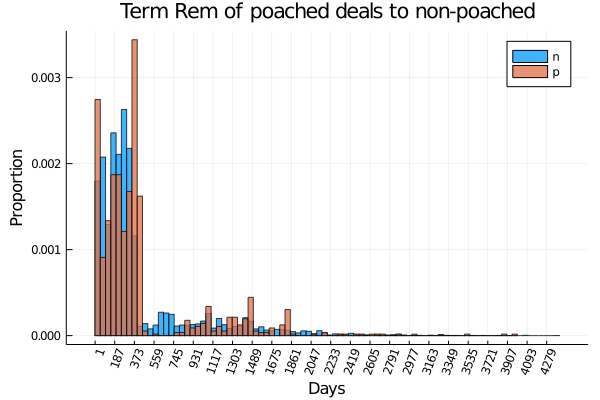

In [274]:
histogram(termrem,xrotation=70,xticks = [i for i in 1:6*31:maximum(termrem)],normed=true,group = contractdf.Poached,bar_position = :dodge,alpha = 0.75,nbins = 100,xlabel="Days",ylabel="Proportion",title="Term Rem of poached deals to non-poached")


In [301]:
head(custdf)
names(custdf)
custdf.termRatio = (custdf.avgTermUsed ./ (custdf.avgTermUsed .+ custdf.avgTermLeft))
custdf.termRatio = coalesce.(custdf.termRatio, 0)

14596-element Array{Real,1}:
 0.7857142857142857
 0.8695652173913043
 0.957790192427064
 0.7538860103626943
 0.8126009693053312
 0.875968992248062
 0.5531135531135531
 1.3855878634639696
 1.138525155065472
 0.8487290762554247
 0.9244410177332305
 0.3333333333333333
 0.8303341902313625
 ?
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [293]:
## plot the customer data to see how the performances of sales reps changes


using VegaLite
names(custdf)

11-element Array{String,1}:
 "AccountNo"
 "custStart"
 "custEnd"
 "RetentionLen"
 "avgTermLeft"
 "avgTermUsed"
 "totalTermRem"
 "totalUsedTerm"
 "numLeases"
 "SalesRep"
 "termRatio"

WARN Infinite extent for field "RetentionLen": [Infinity, -Infinity]
WARN Infinite extent for field "avgTermLeft": [Infinity, -Infinity]
WARN Infinite extent for field "salesRep": [Infinity, -Infinity]
WARN Infinite extent for field "RetentionLen": [Infinity, -Infinity]


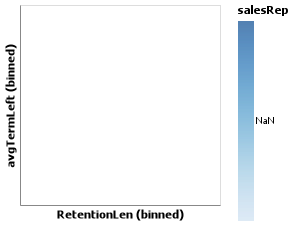

WARN Infinite extent for field "avgTermLeft": [Infinity, -Infinity]
WARN Infinite extent for field "salesRep": [Infinity, -Infinity]


In [302]:


 @vlplot(
    :point,
    x={"salesrep:q", bin=true},
    y={"avgTermLeft:q", bin=true},
    color="salesRep:q"
)

